Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILE_PATH = '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [7]:
# Load preprocessed data for DNN
# example num = 24 * 60
# sequence length = 5
# input size = 4624 + 128*24
fetched_data = np.zeros([24 * 60, 5, 4624+3072])
labels = np.zeros([24 * 60, 5])
data_index = 0

for actor in ACTORS:
  print(actor)
  file_path = FILE_PATH + actor + '/'
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:      
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'
      video = []
      audio = []
      with open(VIDEO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        video = np.array(data)    # (5, 4624)
      with open(AUDIO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        audio = np.array(data)    # (5, 3072)
      fetched_data[data_index] = np.concatenate([video, audio], axis=1)
      label = int(CURRENT_FILE[7])-1
      labels[data_index] = np.full(5, label)
      data_index += 1

Actor_01
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_01/
Actor_02
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_02/
Actor_03
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_03/
Actor_04
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_04/
Actor_05
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_05/
Actor_06
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_06/
Actor_07
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_07/
Actor_08
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_08/
Actor_09
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_09/
Actor_10
/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/Actor_10/
Actor_11
/content/drive/MyDrive/CV_Proje

In [8]:
print(fetched_data[-1])

[[  0.          18.11077028  34.525353   ... -63.49890359 -67.19394081
  -40.11380461]
 [  0.          19.10497317  37.33630941 ... -69.48540507 -80.
  -68.29385923]
 [  0.          16.03121954  32.38826948 ... -80.         -80.
  -80.        ]
 [  0.          18.02775638  36.34556369 ... -76.35828923 -80.
  -80.        ]
 [  0.          18.11077028  35.51056181 ... -74.97122892 -74.97122892
  -74.97122892]]


In [9]:
import random
# example num = 24 * 60
# sequence length = 5
# input size = 4624 / 2816

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.2 * example_nums)

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:]

print(len(random_train_ids), len(random_test_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids,:,:])
Y_train = torch.as_tensor(labels[random_train_ids,:]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids,:,:])
Y_test = torch.as_tensor(labels[random_test_ids,:]).type(torch.int64)

1152 288


In [10]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.features = X

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature = self.features[index]
    label = self.labels[index]
    return feature, label

In [13]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)

print(Y_train)
print(Y_test)
print(X_train)
print(X_test)

tensor([[3, 3, 3, 3, 3],
        [2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        ...,
        [5, 5, 5, 5, 5],
        [2, 2, 2, 2, 2],
        [4, 4, 4, 4, 4]])
tensor([[0, 0, 0, 0, 0],
        [3, 3, 3, 3, 3],
        [7, 7, 7, 7, 7],
        ...,
        [4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3],
        [1, 1, 1, 1, 1]])
tensor([[[  0.0000,  18.2483,  36.4966,  ..., -66.5425, -67.0510, -60.6949],
         [  0.0000,  18.1108,  35.3553,  ..., -77.9505, -79.7976, -58.8061],
         [  0.0000,  17.0000,  34.0000,  ..., -68.9946, -75.5758, -80.0000],
         [  0.0000,  18.0278,  35.2278,  ..., -68.2551, -80.0000, -55.3663],
         [  0.0000,  17.0294,  34.2345,  ..., -80.0000, -80.0000, -80.0000]],

        [[  0.0000,  20.0998,  40.1995,  ..., -78.3359, -72.0426, -64.6250],
         [  0.0000,  21.0950,  41.0488,  ..., -80.0000, -80.0000, -80.0000],
         [  0.0000,  20.0000,  40.0125,  ..., -70.5937, -71.4776, -67.5536],
         [  0.0000,  20.0250,  40.0500,  ..., -77.2655

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [103]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        features, labels = batch 
        out = self(features.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out.to(device), labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch  # features:(128, 5, 7696), labels:(128, 5). (batch , seq, logits)
        # print(features.shape, labels.shape)
        out = self(features.type(torch.FloatTensor).to(device))                    # Generate predictions
        # print('all out', out.shape) # out:(128, 8, 5)
        # Calculate sequence loss
        loss = F.cross_entropy(out.to(device), labels.to(device))   
        acc = accuracy(out.to(device), labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [104]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [105]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [106]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [107]:
# many-to-many
# 
class LSTM(EmotionClassificationBase):
  def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
    super().__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True) # (seq, batch, feature).
    self.fc1 = nn.Linear(hidden_size, num_classes)
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.fc3 = nn.Linear(hidden_size, num_classes)
    self.fc4 = nn.Linear(hidden_size, num_classes)
    self.fc5 = nn.Linear(hidden_size, num_classes)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    x, _ = self.lstm(x, (h0, c0))
    # print('x', x.shape)
    # x: tensor of shape (batch_size, seq_length, hidden_size)
    # out: (batch_size, num_class) * seq_length
    out = torch.rand(x.shape[0], 8, 5)
    out[:,:,0] = self.fc1(x[:, 0, :])
    out[:,:,1] = self.fc2(x[:, 1, :])
    out[:,:,2] = self.fc3(x[:, 2, :])
    out[:,:,3] = self.fc4(x[:, 3, :])
    out[:,:,4] = self.fc5(x[:, 4, :])
    return out

In [108]:
model = LSTM(input_size = 7696, hidden_size = 512, num_layers = 1, num_classes = 8)
model.to(device)

LSTM(
  (lstm): LSTM(7696, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=8, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
  (fc3): Linear(in_features=512, out_features=8, bias=True)
  (fc4): Linear(in_features=512, out_features=8, bias=True)
  (fc5): Linear(in_features=512, out_features=8, bias=True)
)

In [109]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)

In [110]:
history = [evaluate(model, test_dataloader)]
history

[{'val_loss': 2.100285053253174, 'val_acc': 0.6822916865348816}]

In [111]:
history += fit(20, 0.0001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 2.0778, val_acc: 0.6875
Epoch [1], val_loss: 2.0671, val_acc: 0.7396
Epoch [2], val_loss: 2.0619, val_acc: 0.7474
Epoch [3], val_loss: 2.0596, val_acc: 0.7266
Epoch [4], val_loss: 2.0598, val_acc: 0.7448
Epoch [5], val_loss: 2.0579, val_acc: 0.7839
Epoch [6], val_loss: 2.0534, val_acc: 0.8646
Epoch [7], val_loss: 2.0516, val_acc: 0.8516
Epoch [8], val_loss: 2.0487, val_acc: 0.8542
Epoch [9], val_loss: 2.0465, val_acc: 0.9062
Epoch [10], val_loss: 2.0488, val_acc: 0.8333
Epoch [11], val_loss: 2.0469, val_acc: 0.8438
Epoch [12], val_loss: 2.0483, val_acc: 0.8698
Epoch [13], val_loss: 2.0510, val_acc: 0.7891
Epoch [14], val_loss: 2.0515, val_acc: 0.7786
Epoch [15], val_loss: 2.0505, val_acc: 0.8646
Epoch [16], val_loss: 2.0487, val_acc: 0.8229
Epoch [17], val_loss: 2.0496, val_acc: 0.8776
Epoch [18], val_loss: 2.0507, val_acc: 0.8333
Epoch [19], val_loss: 2.0485, val_acc: 0.8854


In [112]:
history += fit(20, 0.00001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 2.0487, val_acc: 0.8906
Epoch [1], val_loss: 2.0484, val_acc: 0.9141
Epoch [2], val_loss: 2.0483, val_acc: 0.9375
Epoch [3], val_loss: 2.0478, val_acc: 0.9401
Epoch [4], val_loss: 2.0471, val_acc: 0.9219
Epoch [5], val_loss: 2.0465, val_acc: 0.9661
Epoch [6], val_loss: 2.0462, val_acc: 0.9740
Epoch [7], val_loss: 2.0457, val_acc: 0.9557
Epoch [8], val_loss: 2.0453, val_acc: 0.9479
Epoch [9], val_loss: 2.0454, val_acc: 0.9661
Epoch [10], val_loss: 2.0450, val_acc: 0.9609
Epoch [11], val_loss: 2.0455, val_acc: 0.9583
Epoch [12], val_loss: 2.0456, val_acc: 0.9479
Epoch [13], val_loss: 2.0455, val_acc: 0.9479
Epoch [14], val_loss: 2.0455, val_acc: 0.9609
Epoch [15], val_loss: 2.0456, val_acc: 0.9427
Epoch [16], val_loss: 2.0450, val_acc: 0.9505
Epoch [17], val_loss: 2.0453, val_acc: 0.9479
Epoch [18], val_loss: 2.0453, val_acc: 0.9531
Epoch [19], val_loss: 2.0450, val_acc: 0.9818


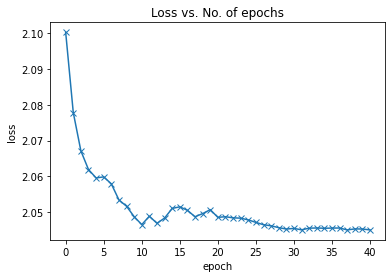

In [113]:
plot_losses(history)

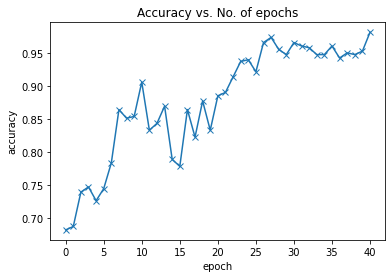

In [114]:
plot_accuracies(history)

In [115]:
evaluate(model, test_dataloader)

{'val_loss': 2.0450174808502197, 'val_acc': 0.9817708134651184}

In [116]:
torch.save(model.state_dict(), 'emotion_classification-feedforward.pth')